In [1]:
# Feel free to import any other libraries and modules.
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import random
from torch.utils.data import Subset

# Part One: Optimization Algorithms
## 1. Gradient Descent
The Gradient Descent (GD) algorithm finds the minimum of a given
function by taking small steps along the function's gradient:

>$\Theta \leftarrow \Theta_0$

>**while** stop condition not met **do**

>$~~~~$$\Theta \leftarrow \Theta - \alpha \nabla_\Theta f(\Theta)$

>**end while**

where $f$ is the function to minimize, $\nabla_\Theta f(\Theta)$
denotes $f$'s gradient at $\Theta$ and $\alpha$ is the learning rate.

**Task1:** Implement the GD algorithm as a function:

  \begin{equation}
      \Theta_{opt} = \text{GD}(f, \Theta_0, \alpha, \rho)
  \end{equation}
where $f$ is a function returning the cost and its gradient with respect to parameter vector $\Theta$, $\Theta_0$ is the initial value, and $\alpha$
is the learning rate. You can assume that $\alpha$. remains constant during the optimization. $\rho$ is stop condition. \\
Then, use the GD algorithm to find the optimum of the [Rosenbrock function](https://en.wikipedia.org/wiki/Rosenbrock_function) (Consider $a=1, b=100$).
 \\
Also, plot the values found by GD at subsequent iterations.

## 2. Newton's Method
Newton's method is an iterative optimization algorithm used to find the minimum of a function.
The basic update step in Newton's method is given by:

\begin{equation}
\Theta = \Theta - H^{-1} \cdot \nabla f(\Theta)
\end{equation}


Where  $ H $ is the Hessian matrix of the function at $ \Theta $, and $ H^{-1} $ is the inverse of the Hessian matrix, used to adjust the step size and direction more accurately than just using the gradient alone (as done in gradient descent).

#### Line Search
Sometimes, Newton's method may take too large of a step, which can lead to divergence. To prevent this, a simple **line search** is used. This reduces the step size $ \alpha $ if the function value doesn't improve after the step.

Steps:
1. Compute the gradient and Hessian matrix at the current point.
2. Calculate the step direction by multiplying the inverse of the Hessian with the gradient.
3. Update the point by subtracting the step from the current point.
4. If the function value doesn't improve, reduce the step size $ \alpha $.
5. Repeat until the gradient becomes sufficiently small (close to zero), indicating convergence.



**Task2:** Implement Newton's method and compare it with the gradient descent. You will also need to implement a line search alogithm, e.g. (https://en.wikipedia.org/wiki/Backtracking_line_search) and make sure that the Newton's direction is indeed one along which the function is minimized.


In [2]:
def rosenbrock(x):
    """Returns the value and gradient of Rosenbrock's function at x: 2d vector"""
    a = 1
    b = 100
    val = (x[0] - a)**2 + b * (x[1] - x[0]**2)**2
    dv_dx0 = -2 * (a - x[0]) - 4 * b * x[0] * (x[1] - x[0]**2)
    dv_dx1 = 2 * b * (x[1] - x[0]**2)
    grad = np.array([dv_dx0, dv_dx1])

    return val, grad

def rosenbrock_hessian(x):
    """Returns the value, gradient and hessian of Rosenbrock's function at x: 2d vector"""
    val, grad = rosenbrock(x)

    a = 1
    b = 100
    # Hessian matrix components
    d2v_dx0x0 = 2 - 4 * b * (x[1] - x[0]**2) + 8 * b * x[0]**2
    d2v_dx0x1 = -4 * b * x[0]
    d2v_dx1x0 = -4 * b * x[0]
    d2v_dx1x1 = 2 * b

    # Hessian matrix
    hessian = np.array([[d2v_dx0x0, d2v_dx0x1],
                [d2v_dx1x0, d2v_dx1x1]])

    return val, grad, hessian


def GD(f, theta0, alpha, stop_tolerance=1e-10, max_steps=1000000):
    """Runs gradient descent algorithm on f.

    Args:
        f: function that when evaluated on a Theta of same dtype and shape as Theta0
            returns a tuple (value, dv_dtheta) with dValuedTheta of the same shape
            as Theta
        theta0: starting point
        alpha: step length
        stop_tolerance: stop iterations when improvement is below this threshold
        max_steps: maximum number of steps
    Returns:
        tuple:
        - theta: optimum theta found by the algorithm
        - history: list of length num_steps containing tuples (theta, (val, dv_dtheta: np.array))

    """
    history = []

    theta = np.array(theta0, dtype=float)

    step = 0
    while step < max_steps:
      val, dv_dtheta = f(theta)
      theta -= alpha * dv_dtheta
      step += 1
      history.append((theta.copy(), f(theta)))
      if np.linalg.norm(dv_dtheta) < stop_tolerance:
        break
    return theta, history

Found optimum at [1. 1.] in 54320 steps (true minimum is at [1,1])


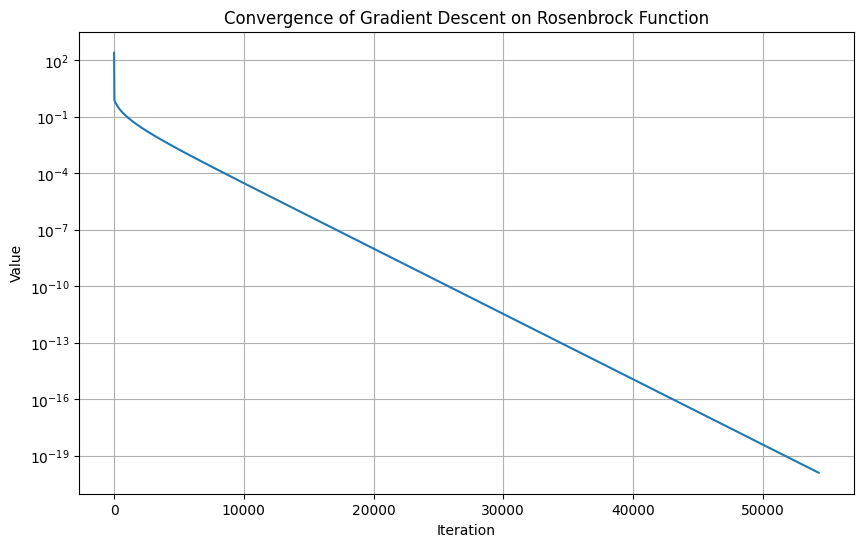

In [4]:
# Find the optimum of rosenbrock function

X0 = [0.,2.]
Xopt, Xhist = GD(rosenbrock, X0, alpha=1e-3, stop_tolerance=1e-10, max_steps=1e6)

print ("Found optimum at %s in %d steps (true minimum is at [1,1])" % (Xopt, len(Xhist)))

# Plot how the value changes over iterations
values = [info[0] for _, info in Xhist]

plt.figure(figsize=(10, 6))
plt.plot(values)
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Convergence of Gradient Descent on Rosenbrock Function')
plt.grid(True)
plt.yscale('log')
plt.show()

In [5]:
# Newton's Method
def line_search(f, theta, step_dir, t=1.0, beta=0.8, c=1e-4):
    val, grad, _ = f(theta)
    while True:
        new_theta = theta + t * step_dir
        new_val, _, _ = f(new_theta)
        if new_val <= val + c * t * np.dot(grad, step_dir):
            break
        t *= beta
    return t

def Newton(f, theta0, alpha=1, stop_tolerance=1e-10, max_steps=1000000):
    """Performs Newton's optimization method with a simple line search.

    Args:
        f: function that when evaluated on a Theta of same dtype and shape as Theta0
            returns a tuple (value, gradient, hessian), where gradient and Hessian
            have the same shape as Theta.
        theta0: starting point.
        alpha: step length for backtracking line search (default is 1).
        stop_tolerance: stop iterations when the norm of the gradient is below this threshold.
        max_steps: maximum number of iterations.
    Returns:
        tuple:
        - theta: optimal Theta after convergence or maximum steps.
        - history: list of tuples (theta, value, gradient) containing the optimization path.
    """
    theta = np.array(theta0, dtype=float)
    history = []

    for step in range(max_steps):
        val, grad, hessian = f(theta)
        if np.linalg.norm(grad) < stop_tolerance:
            break
        step_dir = -np.dot(np.linalg.inv(hessian), grad)
        alpha = line_search(f, theta, step_dir, alpha)
        theta += alpha * step_dir
        history.append((theta.copy(), val, grad.copy()))

    return theta, history

# Test Newton's method on the Rosenbrock function
X0 = [0., 2.]  # Initial guess
Xopt, Xhist = Newton(rosenbrock_hessian, X0)

print("Found optimum at %s (true minimum is at [1,1])" % Xopt)

Found optimum at [1. 1.] (true minimum is at [1,1])


# Part two: MLP for MNIST Classification
In this part, we are going to use `PyTorch`. If you want to become more familiar with it, check this resource: https://www.learnpytorch.io/

#### In this homework, you need to
- implement SGD optimizer (`./optimizer.py`)
- implement forward and backward for FCLayer (`layers.py`)
- implement forward and backward for SigmoidLayer (`layers.py`)
- implement forward and backward for ReLULayer (`layers.py`)
- implement forward and backward for DropoutLayer (`layers.py`)
- implement train and test process (`solver.py`)

In [2]:
import sys
sys.path.append('layers')
sys.path.append('optimizer')
sys.path.append('solver')

In [3]:
from layers import FCLayer, SigmoidLayer, ReLULayer
from solver import train, test
from optimizer import SGD

In [4]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
# Load MNIST dataset

# Converts PIL image to tensor and scales to [0, 1] and flatten it
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1)),
])

# Load MNIST dataset with the defined transform
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# One-hot encoding for labels
def decode_label(label, num_classes=10):
    return torch.nn.functional.one_hot(torch.tensor(label), num_classes=num_classes).float()

# Preprocess labels and combine with transformed images
y_train = [decode_label(label) for _, label in train_dataset]
y_test = [decode_label(label) for _, label in test_dataset]

# Convert the data into tensor datasets for training and testing
train_dataset = TensorDataset(torch.stack([img for img, _ in train_dataset]), torch.stack(y_train))
test_dataset = TensorDataset(torch.stack([img for img, _ in test_dataset]), torch.stack(y_test))

# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [10]:
num_epoch = 20

criterion = nn.MSELoss()

# Build MLP with FCLayer and SigmoidLayer you've implemented in layers.py
sigmoidMLP = nn.Sequential(
    FCLayer(784, 128),
    SigmoidLayer(),
    FCLayer(128, 10)
)

# Initialize optimizer you've implemented in optimizer.py
sgd = SGD(params=sigmoidMLP.parameters(), learning_rate=0.01)

# Train the model using train function you've implemented in solver.py
sigmoidMLP = train(sigmoidMLP, criterion, sgd, train_dataloader, num_epoch, device=device)


Epoch [0] Average training loss: 0.0771, Average training accuracy: 0.4956

Epoch [1] Average training loss: 0.0556, Average training accuracy: 0.7378

Epoch [2] Average training loss: 0.0506, Average training accuracy: 0.7835

Epoch [3] Average training loss: 0.0482, Average training accuracy: 0.8046

Epoch [4] Average training loss: 0.0466, Average training accuracy: 0.8173

Epoch [5] Average training loss: 0.0456, Average training accuracy: 0.8254

Epoch [6] Average training loss: 0.0448, Average training accuracy: 0.8307

Epoch [7] Average training loss: 0.0442, Average training accuracy: 0.8344

Epoch [8] Average training loss: 0.0437, Average training accuracy: 0.8384

Epoch [9] Average training loss: 0.0432, Average training accuracy: 0.8408

Epoch [10] Average training loss: 0.0429, Average training accuracy: 0.8430

Epoch [11] Average training loss: 0.0426, Average training accuracy: 0.8455

Epoch [12] Average training loss: 0.0423, Average training accuracy: 0.8465

Epoch [1

In [11]:
# Test your model using test function you've implemented in solver.py
test(sigmoidMLP, test_dataloader, device)

The test accuracy is 0.8627.



In [12]:
# Build MLP with FCLayer and ReLULayer
reluMLP = nn.Sequential(
    FCLayer(784, 128),
    ReLULayer(),
    FCLayer(128, 10)
)

# Initialize optimizer
sgd = SGD(reluMLP.parameters(), learning_rate=0.01)

# Train the model
reluMLP = train(reluMLP, criterion, sgd, train_dataloader, num_epoch, device=device)


Epoch [0] Average training loss: 0.0712, Average training accuracy: 0.6373

Epoch [1] Average training loss: 0.0467, Average training accuracy: 0.8231

Epoch [2] Average training loss: 0.0399, Average training accuracy: 0.8589

Epoch [3] Average training loss: 0.0357, Average training accuracy: 0.8765

Epoch [4] Average training loss: 0.0327, Average training accuracy: 0.8875

Epoch [5] Average training loss: 0.0305, Average training accuracy: 0.8953

Epoch [6] Average training loss: 0.0288, Average training accuracy: 0.9011

Epoch [7] Average training loss: 0.0274, Average training accuracy: 0.9060

Epoch [8] Average training loss: 0.0262, Average training accuracy: 0.9103

Epoch [9] Average training loss: 0.0253, Average training accuracy: 0.9131

Epoch [10] Average training loss: 0.0244, Average training accuracy: 0.9162

Epoch [11] Average training loss: 0.0237, Average training accuracy: 0.9185

Epoch [12] Average training loss: 0.0231, Average training accuracy: 0.9205

Epoch [1

In [13]:
# Test the model
test(reluMLP, test_dataloader, device)

The test accuracy is 0.9313.



### Overfit the model
Try to overfit the reluMLP model. You can make the model as complex as you like, use subset of the data for training or any other approach you want.
Then add **DropoutLayer** to your model in order to reduce overfitting problem.

In [6]:
# Overfit the reluMLP model

# Reducing the dataset size
num_samples = int(len(train_dataset) * 0.05)
small_train_dataset = torch.utils.data.Subset(train_dataset, range(num_samples))
small_train_dataloader = torch.utils.data.DataLoader(small_train_dataset, batch_size=32, shuffle=True)

# A more complex MLP model with additional layers
complexMLP = nn.Sequential(
    FCLayer(784, 256),
    nn.BatchNorm1d(256),
    ReLULayer(),
    FCLayer(256, 128),
    nn.BatchNorm1d(128),
    ReLULayer(),
    FCLayer(128, 64),
    nn.BatchNorm1d(64),
    ReLULayer(),
    FCLayer(64, 10)
)


# Increasing number of epochs
num_epoch = 50
criterion = nn.MSELoss()
sgd = SGD(complexMLP.parameters(), learning_rate=0.01)
complexMLP = train(complexMLP, criterion, sgd, small_train_dataloader, num_epoch, device=device)


Epoch [0] Average training loss: 0.5144, Average training accuracy: 0.2273

Epoch [1] Average training loss: 0.2574, Average training accuracy: 0.3865

Epoch [2] Average training loss: 0.1947, Average training accuracy: 0.4817

Epoch [3] Average training loss: 0.1609, Average training accuracy: 0.5352

Epoch [4] Average training loss: 0.1379, Average training accuracy: 0.5862

Epoch [5] Average training loss: 0.1224, Average training accuracy: 0.6383

Epoch [6] Average training loss: 0.1095, Average training accuracy: 0.6519

Epoch [7] Average training loss: 0.1006, Average training accuracy: 0.6653

Epoch [8] Average training loss: 0.0952, Average training accuracy: 0.6978

Epoch [9] Average training loss: 0.0875, Average training accuracy: 0.7169

Epoch [10] Average training loss: 0.0807, Average training accuracy: 0.7422

Epoch [11] Average training loss: 0.0781, Average training accuracy: 0.7516

Epoch [12] Average training loss: 0.0746, Average training accuracy: 0.7579

Epoch [1

In [7]:
test(complexMLP, test_dataloader, device)

The test accuracy is 0.8525.



In [8]:
from layers import DropoutLayer

complexMLP_with_dropout = nn.Sequential(
    FCLayer(784, 256),
    nn.BatchNorm1d(256),
    ReLULayer(),
    DropoutLayer(dropout_rate=0.05),
    FCLayer(256, 128),
    nn.BatchNorm1d(128),
    ReLULayer(),
    DropoutLayer(dropout_rate=0.05),
    FCLayer(128, 64),
    nn.BatchNorm1d(64),
    ReLULayer(),
    DropoutLayer(dropout_rate=0.05),
    FCLayer(64, 10)
)

sgd = SGD(complexMLP_with_dropout.parameters(), learning_rate=0.01)
complexMLP_with_dropout = train(complexMLP_with_dropout, criterion, sgd, small_train_dataloader, num_epoch, device=device)


Epoch [0] Average training loss: 0.6048, Average training accuracy: 0.1975

Epoch [1] Average training loss: 0.3259, Average training accuracy: 0.3071

Epoch [2] Average training loss: 0.2534, Average training accuracy: 0.3901

Epoch [3] Average training loss: 0.2116, Average training accuracy: 0.4445

Epoch [4] Average training loss: 0.1871, Average training accuracy: 0.4803

Epoch [5] Average training loss: 0.1673, Average training accuracy: 0.5148

Epoch [6] Average training loss: 0.1500, Average training accuracy: 0.5404

Epoch [7] Average training loss: 0.1412, Average training accuracy: 0.5537

Epoch [8] Average training loss: 0.1288, Average training accuracy: 0.5809

Epoch [9] Average training loss: 0.1222, Average training accuracy: 0.5880

Epoch [10] Average training loss: 0.1134, Average training accuracy: 0.6283

Epoch [11] Average training loss: 0.1100, Average training accuracy: 0.6229

Epoch [12] Average training loss: 0.1037, Average training accuracy: 0.6431

Epoch [1

In [9]:
test(complexMLP_with_dropout, test_dataloader, device)

The test accuracy is 0.8564.



The results are mostly in line with expectations. With a smaller dataset, we expect the model to overfit more easily, and adding complexity (additional layers) generally increases the model's capacity to learn intricate patterns within the limited dataset.

After using dropout layers, the traning accuracies have reduced. The test accuracy have improved slightly with dropout layers. These show that dropout layers have decreased overfitting, because regularization effect makes it harder for the model to memorize the exact details of the training data, lowering training accuracy slightly but preventing overfitting.

Since the dataset size is reduced, aggressive dropout (like 0.5) would significantly hurt learning by dropping too many neurons. This would essentially "shrink" the model's effective capacity, making it harder for the model to fit the limited data. That's why we used a smaller dropout probability.